In [39]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from sklearn.utils import shuffle
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

Dataset on kaggle:

https://www.kaggle.com/datasets/stefancomanita/hourly-electricity-consumption-and-production/data


<h1>Importing dataset and preparing the data</h1>

In [40]:
df = pd.read_csv("electricityConsumptionAndProductioction.csv")

In [41]:
df

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30
...,...,...,...,...,...,...,...,...,...,...
46006,2024-03-31 19:00:00,5618,5902,1398,505,2294,1012,620,6,65
46007,2024-03-31 20:00:00,6107,6205,1395,671,2389,1037,645,0,66
46008,2024-03-31 21:00:00,5991,5855,1395,868,2201,705,621,0,66
46009,2024-03-31 22:00:00,5527,5726,1393,908,2088,648,622,0,66


As a target variables I will choose "Oil and gas" and "Consumption"

In [42]:
df = df[["DateTime", "Consumption", "Oil and Gas"]]

In [43]:
scaler = MinMaxScaler()

# Scale only relevant variables
num_cols = ['Consumption', 'Oil and Gas']
df[num_cols] = scaler.fit_transform(df[num_cols])

/var/folders/19/0ldx1bc54jx5tvjkrsbcv4040000gn/T/ipykernel_47127/2888825201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols] = scaler.fit_transform(df[num_cols])


In [44]:
# Create new sequence varable instead of datetime
df['sequence'] = df.index + 1
df = df.drop(['DateTime'], axis=1)

/var/folders/19/0ldx1bc54jx5tvjkrsbcv4040000gn/T/ipykernel_47127/761976827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sequence'] = df.index + 1


<h1>Splitting into timesteps</h1>

In [45]:
# Timestep one week
timestep_size = 168

# separate the output variables
meantemp = df['Consumption'].values
wind_speed = df['Oil and Gas'].values

# generate timestep windows for each signal
meantemp_windows = sliding_window_view(meantemp, window_shape=timestep_size)
wind_speed_windows = sliding_window_view(wind_speed, window_shape=timestep_size)

# combine into X and y
# use vstack to combine temperatures and wind speeds back together
X = np.vstack((meantemp_windows, wind_speed_windows))

# generate zeroes and ones for the output categories
# 0 = meantemp
# 1 = wind_speed
y = np.array([0] * len(meantemp_windows) + [1] * len(wind_speed_windows))

print("X:", X.shape)
print("y:", y.shape)

X: (91688, 168)
y: (91688,)


In [46]:
# shuffle the data
X, y = shuffle(X, y, random_state=777)

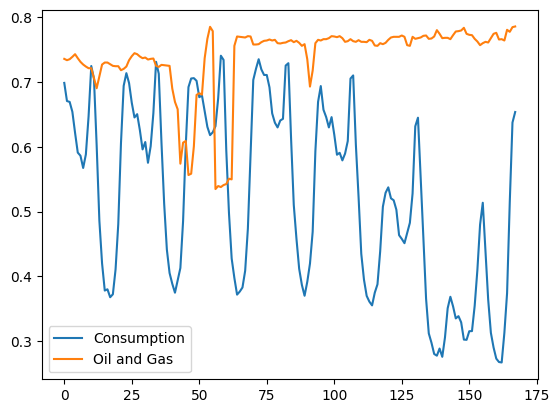

In [47]:
# Plot our timestep
test_signal_index = 1


c_x_train = X[y == 0]
plt.plot(c_x_train[test_signal_index], label="Consumption")

c_x_train = X[y == 1]
plt.plot(c_x_train[test_signal_index], label="Oil and Gas")
plt.legend()

I guess it will be quite easy for the model to find out who is who. Daily consumtion has quite high daily seasonality - people use electricity only during daytime and in the evening, not in the night. In turn, oil and gas by logic shouldn't fluctuate that much

<h1> Train/test split</H1>

In [48]:
# define the cutoff point
# let's leave 0.2
train_size = 0.8
splitter = int(len(X) * train_size)

# split to train/test
x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

In [49]:
# Reshape to CNN format
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

<h1>Initializing model</H1>
Since the data is quite easy, I was trying to make the model as simple as possible

Sometimes it was too simple: 

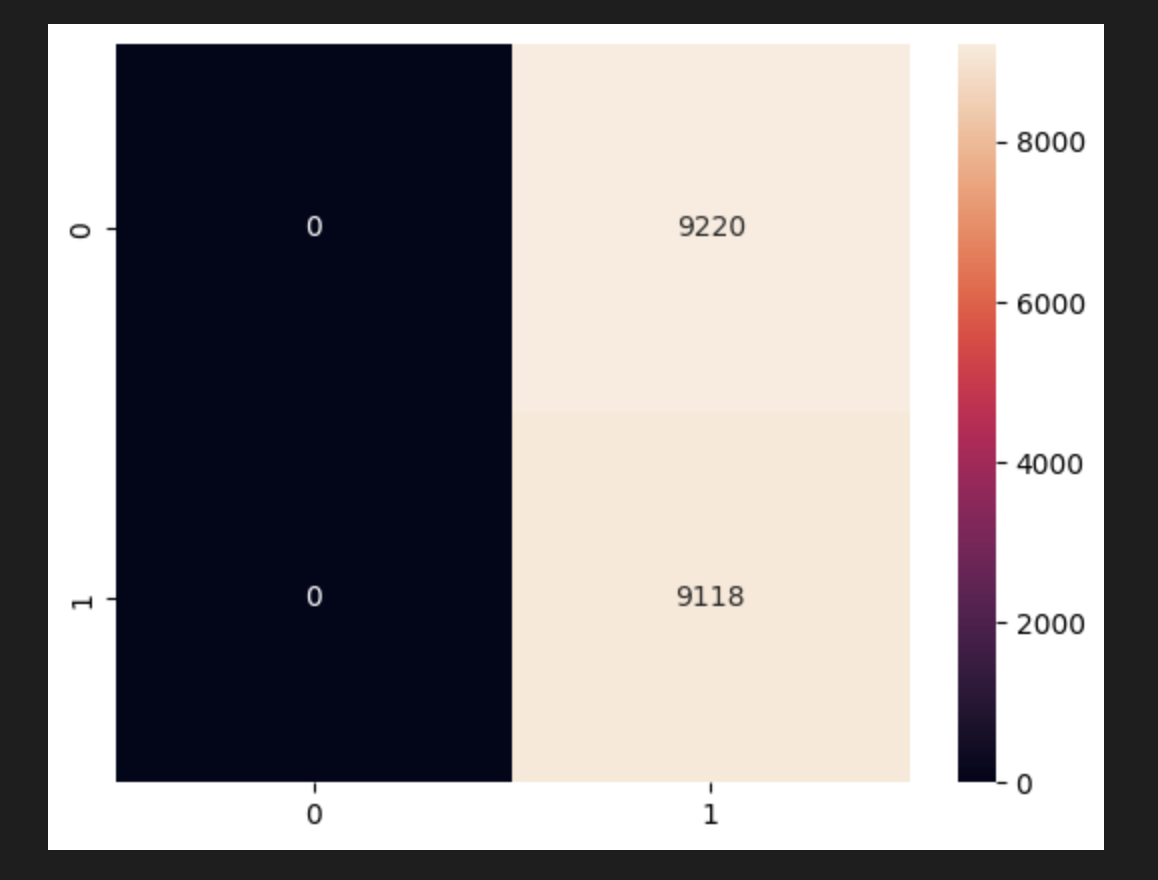

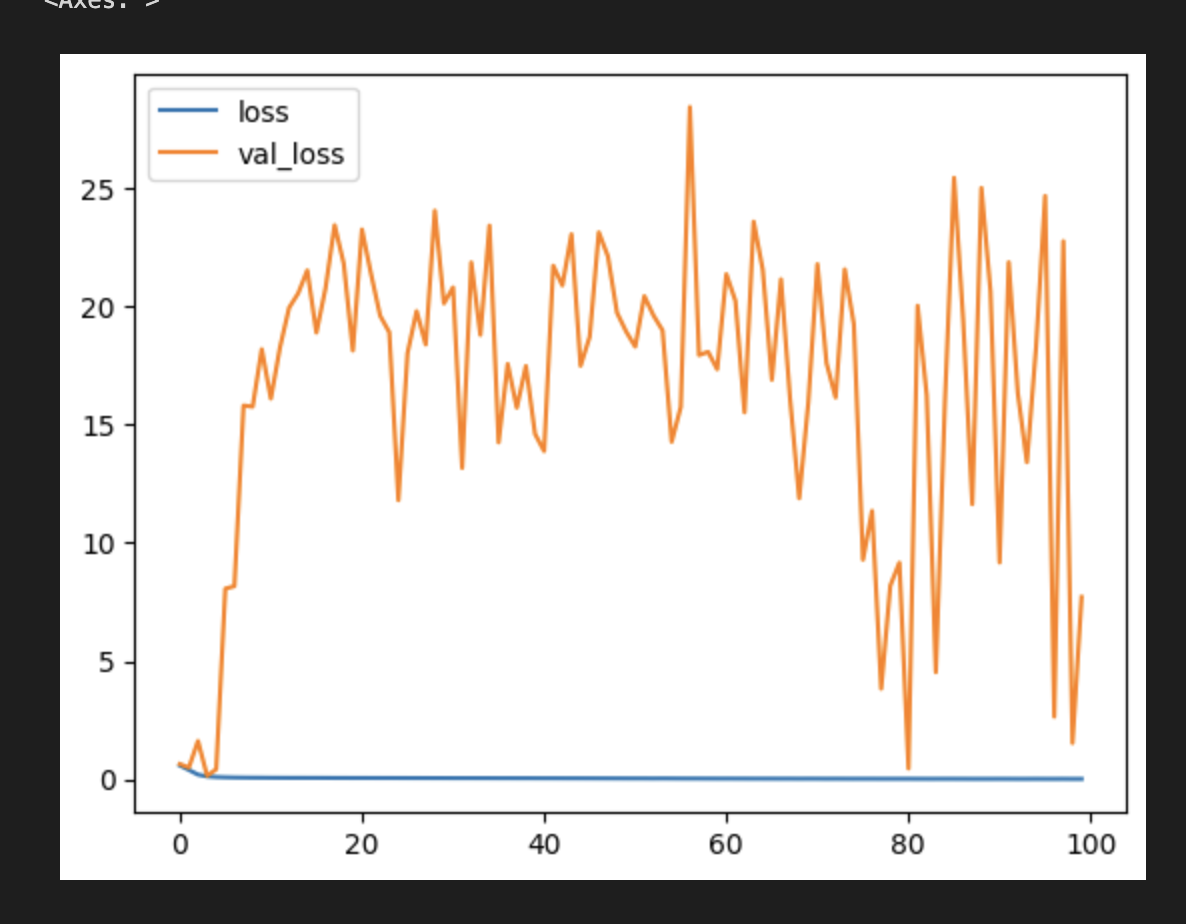

In [50]:
# define class names
class_names = np.array(["Consumption", "Oil and Gas"])
num_classes = len(class_names)
classes = [0, 1]

def make_model(input_shape):
    model = keras.Sequential(
        [
            # input layer
            keras.layers.Input(input_shape),

            # convolutional layer 1 (we usually have 1-3 convolutional layers
            # depending how much and how complex the data is) -> "model capacity / decision space"
            keras.layers.Conv1D(filters=24, kernel_size=3, padding="same"),
            keras.layers.BatchNormalization(),
            keras.layers.ReLU(),

            # pooling + flatten (adapter from convolutional to dense)
            # flattening is done only once after the final convolutional layer 
            # and before the Dense-network
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Flatten(),

            # neural network Dense-tail
            keras.layers.Dense(16, activation="relu"),

            # output layer
            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )

    return model


model = make_model(input_shape=x_train.shape[1:])


<h1>Training</h1>

In [51]:
epochs = 100
batch_size = 256

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),

]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.5966 - sparse_categorical_accuracy: 0.6405 - val_loss: 0.9642 - val_sparse_categorical_accuracy: 0.5076
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1893 - sparse_categorical_accuracy: 0.9589 - val_loss: 1.7035 - val_sparse_categorical_accuracy: 0.5076
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0561 - sparse_categorical_accuracy: 0.9873 - val_loss: 0.5004 - val_sparse_categorical_accuracy: 0.7496
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0350 - sparse_categorical_accuracy: 0.9897 - val_loss: 5.7116 - val_sparse_categorical_accuracy: 0.5076
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0237 - sparse_categorical_accuracy: 0.9929 - val_loss: 14.8561 - val_sparse_categorical_accuracy: 0.5076
Epoch 6/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9946 - val_loss: 19.5542 - val_sparse_categorical_accuracy: 0

<h1>Training loss and accuracy plots</h1>

<Axes: >

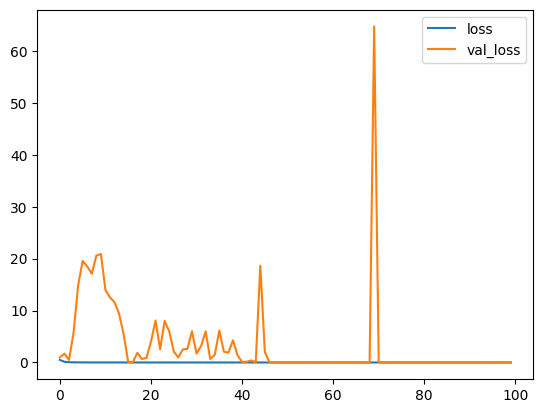

In [52]:
# plot validation loss and loss
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

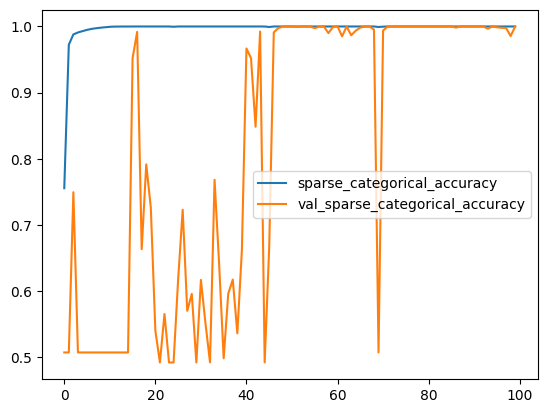

In [53]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot() 

Both are fluctuating a bit, but i guess it is normal for times series data

In [54]:
 # compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:


[2.1443092919071205e-05, 1.0]

Train data evaluation:
[1.4064370589039754e-05, 1.0]


There is a minor difference, but in general values are quite matching

<h1>Predictions and metrics</h1>

In [55]:
 # get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step


<Axes: >

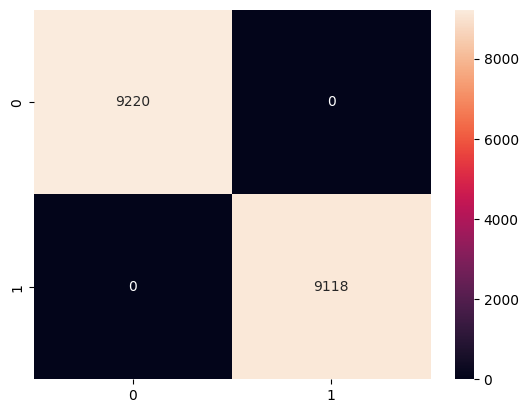

In [56]:
# confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')  

Aaaaan zero mistakes

In [57]:
 # print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9220
           1       1.00      1.00      1.00      9118

    accuracy                           1.00     18338
   macro avg       1.00      1.00      1.00     18338
weighted avg       1.00      1.00      1.00     18338


Model overall accuracy: 100.00%


<h1>AI generated test data</h1>

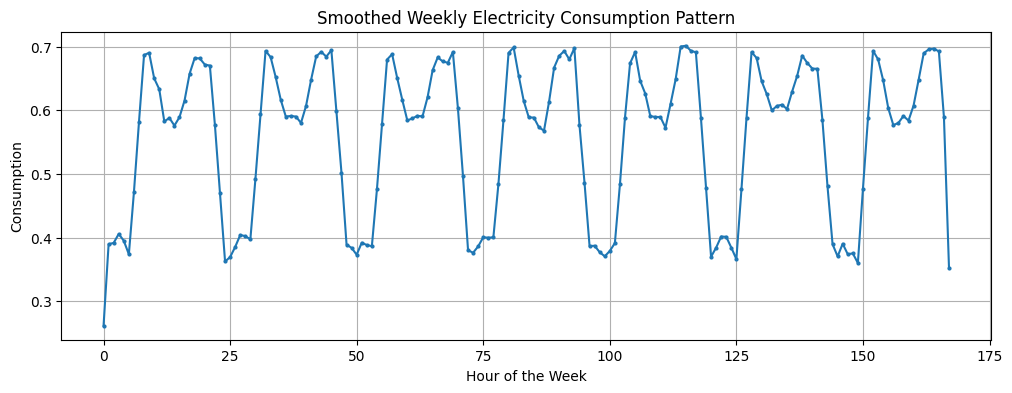

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Generate X values (0 to 167 hours in a week)
X = np.arange(168)

# Define a function for a more stable daily consumption pattern
def daily_pattern(hour):
    # Higher consumption during morning (7-10 AM) and evening (5-10 PM)
    if 7 <= hour % 24 <= 10 or 17 <= hour % 24 <= 22:
        return np.random.uniform(0.65, 0.72)  # Narrower range for stability
    # Medium consumption during daytime (10 AM - 5 PM)
    elif 10 < hour % 24 < 17:
        return np.random.uniform(0.55, 0.62)
    # Low consumption at night (10 PM - 7 AM)
    else:
        return np.random.uniform(0.35, 0.42)

# Generate Y values with a smoother pattern
Y = np.array([daily_pattern(hour) for hour in X])

# Apply a simple smoothing filter (moving average)
Y_consumption = np.convolve(Y, np.ones(3)/3, mode='same')

# Plot to visualize
plt.figure(figsize=(12, 4))
plt.plot(X, Y_consumption, marker="o", markersize=2, linestyle="-")
plt.xlabel("Hour of the Week")
plt.ylabel("Consumption")
plt.title("Smoothed Weekly Electricity Consumption Pattern")
plt.grid()
plt.show()


In [69]:
test_signal = np.expand_dims(Y_consumption, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[1.000000e+00 2.286778e-09]]
Consumption


While testing with chat gpt, I've noticed that if fluctations were too sharp in consumption, model struggled to recognize it. I think with a little bit increased complexity of the model it wouldn't be the problem.

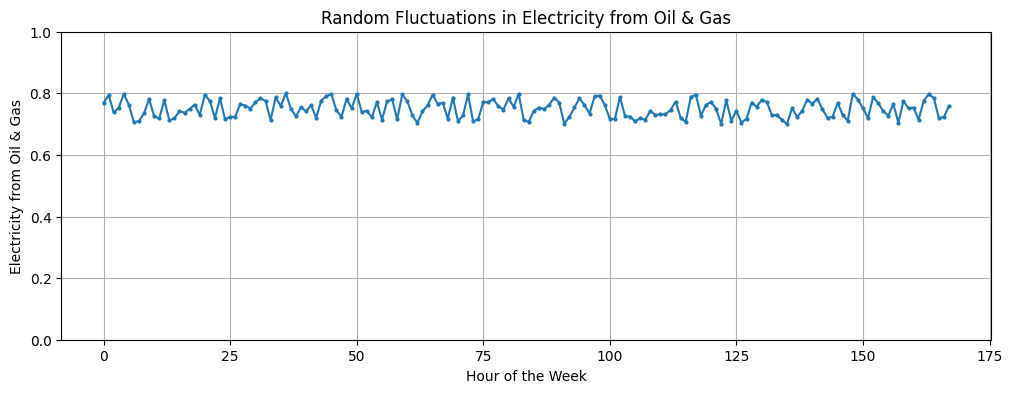

In [71]:
# Generate Y values randomly between 0.7 and 0.8
Y_oil = np.random.uniform(0.7, 0.8, size=168)

# Plot to visualize
plt.figure(figsize=(12, 4))
plt.plot(X, Y_oil, marker="o", markersize=2, linestyle="-")
plt.xlabel("Hour of the Week")
plt.ylabel("Electricity from Oil & Gas")
plt.title("Random Fluctuations in Electricity from Oil & Gas")
plt.grid()
plt.ylim(0, 1)
plt.show()


In [70]:
test_signal = np.expand_dims(Y_oil, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[1.3550038e-19 1.0000000e+00]]
Oil and Gas
